## Лабораторна робота №4: Дослідження окремих блоків та шарів згорткових нейронних мереж

Мета роботи полягає у дослідженні впливу спеціальних блоків на ефективність згорткових нейронних мереж. В рамках роботи реалізовано та порівняно три архітектурні модифікації базової мережі ResNet18: Squeeze-and-Excitation (SE) блоки, розширені згортки та Inception блоки.

In [1]:
# %% [Cell 1]: Imports and Global Settings
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from typing import Tuple, Dict, List, Union, Optional
import time
from pathlib import Path
import matplotlib.pyplot as plt

# Set default device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Ensure reproducibility
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)
np.random.seed(42)

# Create directory for saving models
save_dir = Path('model_checkpoints')
save_dir.mkdir(exist_ok=True)

Using device: cuda


### Підготовка даних та налаштування середовища
У цій частині виконуємо налаштування PyTorch, завантажуємо датасет CIFAR-10 та налаштовуємо генератори даних для навчання, валідації та тестування. Датасет CIFAR-10 містить 60000 кольорових зображень розміром 32x32 пікселі, розділених на 10 класів. Використовується стандартна аугментація даних: випадкове обрізання та горизонтальне відображення.

In [2]:
# %% [Cell 2]: Data Preparation and Loading

def prepare_cifar10(
    batch_size: int = 128, 
    validation_split: float = 0.1,
    random_seed: int = 42,
    transform_train: Optional[transforms.Compose] = None,
    transform_val: Optional[transforms.Compose] = None
) -> Tuple[DataLoader, DataLoader, DataLoader, Dict]:
    """
    Prepares CIFAR10 dataset with train/val/test splits and given transforms.
    """
    
    # Set seeds for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    
    # Default transforms if none provided
    if transform_train is None:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465), 
                (0.2023, 0.1994, 0.2010)
            )
        ])
    if transform_val is None:
        transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465), 
                (0.2023, 0.1994, 0.2010)
            )
        ])
    
    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_val
    )
    
    # Split train into train/val
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(validation_split * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=2, pin_memory=True
    )
    val_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=val_sampler,
        num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )
    
    # Store dataset information
    dataset_info = {
        'num_classes': 10,
        'num_channels': 3,
        'image_size': 32,
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'test_size': len(test_dataset),
    }
    
    return train_loader, val_loader, test_loader, dataset_info

# Load and prepare the dataset
train_loader, val_loader, test_loader, dataset_info = prepare_cifar10()
print("Dataset loaded with following properties:")
for key, value in dataset_info.items():
    print(f"{key}: {value}")

Files already downloaded and verified
Files already downloaded and verified
Dataset loaded with following properties:
num_classes: 10
num_channels: 3
image_size: 32
train_size: 45000
val_size: 5000
test_size: 10000


### Реалізація Squeeze-and-Excitation Block
Squeeze-and-Excitation блок дозволяє мережі динамічно перезважувати канальні ознаки. Процес складається з двох етапів:

- "Squeeze" - глобальне усереднення для отримання канального дескриптора
- "Excitation" - адаптивне перезважування через два повнозв'язні шари

Реалізований блок можна додавати до будь-якого згорткового шару для покращення його репрезентативної здатності.

In [3]:
# %% [Cell 3]: Special CNN Blocks Implementation

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block as described in the lab document.
    
    Steps:
    1. Input feature maps from conv block
    2. Global average pooling ("squeeze")
    3. Two FC layers with ReLU and Sigmoid ("excitation")
    4. Scale original feature maps with excitation values
    """
    def __init__(self, in_channels: int, reduction_ratio: int = 16):
        super(SEBlock, self).__init__()
        
        # Ensure reduction doesn't make channels = 0
        reduced_channels = max(1, in_channels // reduction_ratio)
        
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, reduced_channels),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get batch, channels, height, width
        b, c, _, _ = x.size()
        
        # Squeeze: Global average pooling
        y = self.squeeze(x).view(b, c)
        
        # Excitation: FC layers
        y = self.excitation(y).view(b, c, 1, 1)
        
        # Scale: Multiply input with attention weights
        return x * y.expand_as(x)


# Create a simple test to verify the SE block works
def test_se_block():
    # Test input
    x = torch.randn(2, 64, 32, 32)  # (batch, channels, height, width)
    
    # Create SE block
    se_block = SEBlock(64)
    
    # Forward pass
    y = se_block(x)
    
    # Print shapes
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    print(f"Shapes match: {x.shape == y.shape}")

# Run test
test_se_block()

Input shape: torch.Size([2, 64, 32, 32])
Output shape: torch.Size([2, 64, 32, 32])
Shapes match: True


### Реалізація блоку з розширеною згорткою
Розширена згортка дозволяє збільшити рецептивне поле мережі без збільшення кількості параметрів. В нашій реалізації використовуються паралельні гілки з різними коефіцієнтами розширення (dilation rates). Це дає можливість мережі ефективно обробляти як локальні деталі, так і більш широкий контекст зображення.

In [4]:
# %% [Cell 4]: Dilated Convolution Block Implementation

class DilatedConvBlock(nn.Module):
    """
    Dilated Convolution Block that maintains spatial dimensions while expanding receptive field.
    
    Updated:
    - Use two dilation rates [1, 2] to ensure output channels are divisible by 2.
    - Ensure out_channels == in_channels for compatibility with residual blocks.
    """
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int,
        dilation_rates: List[int] = [1, 2]  # changed from [1,2,4] to [1,2]
    ):
        super(DilatedConvBlock, self).__init__()
        
        num_paths = len(dilation_rates)  # now = 2
        # Ensure out_channels == in_channels for residual integrity
        # since we want to return exactly 'planes' channels.
        if out_channels != in_channels:
            raise ValueError("For residual compatibility, out_channels must match in_channels in DilatedConvBlock.")
        
        # Check divisibility
        if out_channels % num_paths != 0:
            raise ValueError(
                f"out_channels ({out_channels}) must be divisible by number of dilation paths ({num_paths})."
            )
        
        self.channels_per_path = out_channels // num_paths
        
        self.dilated_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    self.channels_per_path,
                    kernel_size=3,
                    padding=rate,  # Maintain spatial dimensions
                    dilation=rate,
                    bias=False
                ),
                nn.BatchNorm2d(self.channels_per_path),
                nn.ReLU(inplace=True)
            ) for rate in dilation_rates
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = [conv(x) for conv in self.dilated_convs]
        return torch.cat(features, dim=1)

### Реалізація Inception Block
Inception блок забезпечує паралельну обробку вхідного тензора через різні згорткові фільтри. Реалізовано чотири паралельні шляхи:

- Згортка 1×1
- Послідовність згорток 1×1 та 3×3
- Послідовність згорток 1×1 та 5×5
- Максимальний пулінг з подальшою згорткою 1×1

In [5]:
# %% [Cell 5]: Inception Block Implementation

class InceptionBlock(nn.Module):
    """
    Inception Block implementing parallel paths with different kernels.
    
    Features:
    - 1x1 convolution path
    - 1x1 -> 3x3 convolution path
    - 1x1 -> 5x5 convolution path
    - 3x3 maxpool -> 1x1 convolution path
    """
    def __init__(
        self,
        in_channels: int,
        ch1x1: int,
        ch3x3_reduce: int,
        ch3x3: int,
        ch5x5_reduce: int,
        ch5x5: int,
        pool_proj: int
    ):
        super(InceptionBlock, self).__init__()
        
        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 -> 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(ch3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )
        
        # 1x1 -> 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(ch5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )
        
        # 3x3 maxpool -> 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Process input through each branch
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        # Concatenate branch outputs along channel dimension
        return torch.cat([branch1, branch2, branch3, branch4], dim=1)


# Test function for Inception Block
def test_inception_block():
    # Test input
    x = torch.randn(2, 64, 32, 32)  # (batch, channels, height, width)
    
    # Create inception block with typical channel configuration
    inception_block = InceptionBlock(
        in_channels=64,
        ch1x1=20,
        ch3x3_reduce=16,
        ch3x3=24,
        ch5x5_reduce=8,
        ch5x5=12,
        pool_proj=12
    )
    
    # Forward pass
    y = inception_block(x)
    
    # Calculate total output channels
    total_channels = 20 + 24 + 12 + 12  # sum of output channels from each branch
    
    # Print information
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    print(f"Expected output channels: {total_channels}")
    print(f"Actual output channels: {y.shape[1]}")
    print(f"Spatial dimensions maintained: {x.shape[2:] == y.shape[2:]}")

# Run test
test_inception_block()

Input shape: torch.Size([2, 64, 32, 32])
Output shape: torch.Size([2, 68, 32, 32])
Expected output channels: 68
Actual output channels: 68
Spatial dimensions maintained: True


### Модифікована архітектура ResNet18
На основі базової архітектури ResNet18 реалізовано клас ModifiedResNet18, який дозволяє використовувати різні типи блоків. Базовий залишковий блок може бути розширений SE, розширеними згортками або Inception блоками. Всі модифікації зберігають загальну структуру мережі, змінюючи лише внутрішню організацію блоків.

In [6]:
# %% [Cell 6]: Modified BasicBlock and ModifiedResNet18

class ModifiedBasicBlock(nn.Module):
    """
    Modified BasicBlock that can include SE, Dilated Conv, or Inception blocks.
    
    Updated:
    - Ensure chosen parameters for InceptionBlock sum up to 'planes'.
    - Ensure dilated block and inception block do not change channel counts.
    """
    expansion = 1

    def __init__(
        self, 
        in_planes: int, 
        planes: int, 
        stride: int = 1,
        use_se: bool = False,
        use_dilated: bool = False,
        use_inception: bool = False
    ):
        super(ModifiedBasicBlock, self).__init__()
        
        self.use_se = use_se
        self.use_dilated = use_dilated
        self.use_inception = use_inception
        
        # Main conv layers (no channel change)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        # Special blocks
        # SE block does not change channel count
        self.se = SEBlock(planes) if use_se else None
        
        # DilatedConvBlock should preserve channel count == planes
        # We adjusted DilatedConvBlock to require out_channels == in_channels
        if use_dilated:
            self.dilated = DilatedConvBlock(planes, planes, dilation_rates=[1, 2])
        else:
            self.dilated = None
        
        # InceptionBlock parameters chosen so that sum of outputs = planes
        # For example, split planes into 4 equal parts:
        # ch1x1 = planes//4
        # ch3x3_reduce = planes//8, ch3x3 = planes//4
        # ch5x5_reduce = planes//8, ch5x5 = planes//4
        # pool_proj = planes//4
        # Each branch outputs planes//4 channels, total = planes.
        if use_inception:
            if planes % 8 != 0:
                raise ValueError("For inception configuration, 'planes' must be divisible by 8.")
            self.inception = InceptionBlock(
                in_channels=planes,
                ch1x1=planes//4,
                ch3x3_reduce=planes//8, ch3x3=planes//4,
                ch5x5_reduce=planes//8, ch5x5=planes//4,
                pool_proj=planes//4
            )
        else:
            self.inception = None

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes, self.expansion * planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Apply special blocks
        if self.se is not None:
            out = self.se(out)
        if self.dilated is not None:
            out = self.dilated(out)  # returns same #channels = planes
        if self.inception is not None:
            out = self.inception(out)  # returns same #channels = planes
            
        out += self.shortcut(x)
        return self.relu(out)


class ModifiedResNet18(nn.Module):
    """
    ResNet18 architecture with optional SE, Dilated Conv, or Inception blocks.
    Updated:
    - If using dilated: ensure planes is divisible by 2 (already satisfied by 64,128,256,512)
    - If using inception: ensure planes is divisible by 8.
    """
    def __init__(
        self, 
        num_classes: int = 10,
        block_type: str = 'basic'  # 'basic', 'se', 'dilated', or 'inception'
    ):
        super(ModifiedResNet18, self).__init__()
        self.block_type = block_type
        
        use_se = (block_type == 'se')
        use_dilated = (block_type == 'dilated')
        use_inception = (block_type == 'inception')
        
        if use_inception:
            # 64, 128, 256, 512 are all divisible by 8, so it's fine
            pass
        
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(64, 2, stride=1, use_se=use_se, use_dilated=use_dilated, use_inception=use_inception)
        self.layer2 = self._make_layer(128, 2, stride=2, use_se=use_se, use_dilated=use_dilated, use_inception=use_inception)
        self.layer3 = self._make_layer(256, 2, stride=2, use_se=use_se, use_dilated=use_dilated, use_inception=use_inception)
        self.layer4 = self._make_layer(512, 2, stride=2, use_se=use_se, use_dilated=use_dilated, use_inception=use_inception)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ModifiedBasicBlock.expansion, num_classes)
        
        self._initialize_weights()

    def _make_layer(self, planes, num_blocks, stride, use_se, use_dilated, use_inception):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(
                ModifiedBasicBlock(
                    self.in_planes, planes, stride,
                    use_se=use_se,
                    use_dilated=use_dilated,
                    use_inception=use_inception
                )
            )
            self.in_planes = planes * ModifiedBasicBlock.expansion
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [7]:
# Training Utilities

class AverageMeter:
    """Tracks and stores averages and current values."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = self.sum = self.count = 0
        self.avg = 0

    def update(self, val: float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:
    model.train()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct = predicted.eq(targets).sum().item()
        
        losses.update(loss.item(), inputs.size(0))
        accuracy.update(correct / inputs.size(0), inputs.size(0))
    return losses.avg, accuracy.avg

def validate(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.eval()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            _, predicted = outputs.max(1)
            correct = predicted.eq(targets).sum().item()
            
            losses.update(loss.item(), inputs.size(0))
            accuracy.update(correct / inputs.size(0), inputs.size(0))
    return losses.avg, accuracy.avg

### Налаштування процесу навчання
Для навчання використовуємо:

- Оптимізатор Adam з початковою швидкістю навчання 0.001
- Функцію втрат CrossEntropyLoss
- Зменшення швидкості навчання при відсутності покращення (ReduceLROnPlateau)
- Ранню зупинку з терпінням 10 епох
- Збереження найкращої моделі за валідаційною точністю

### Навчання базової моделі ResNet18
Спочатку навчаємо базову модель ResNet18 без модифікацій. Це дасть нам точку відліку для порівняння ефективності різних архітектурних модифікацій.

In [8]:
# %% [Cell 7]: Train Baseline ResNet18 Model

# Create baseline model
model = ModifiedResNet18(block_type='basic').to(device)
print("Created baseline ResNet18 model")

# Training parameters
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_times': []
}

# Early stopping parameters
best_val_acc = 0.0
patience = 10
patience_counter = 0

print("\nStarting training...")
for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )
    
    epoch_time = time.time() - epoch_start
    
    # Update learning rate scheduler
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Early stopping and model saving logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            model.state_dict(),
            save_dir / 'resnet18_baseline_best.pth'
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs')
            break
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['epoch_times'].append(epoch_time)
    
    # Print progress
    print(
        f'Epoch {epoch+1}/{num_epochs} | '
        f'Train Loss: {train_loss:.4f} | '
        f'Train Acc: {train_acc:.4f} | '
        f'Val Loss: {val_loss:.4f} | '
        f'Val Acc: {val_acc:.4f} | '
        f'LR: {current_lr:.6f} | '
        f'Time: {epoch_time:.2f}s | '
        f'Early Stop Counter: {patience_counter}/{patience}'
    )

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

Created baseline ResNet18 model

Starting training...
Epoch 1/100 | Train Loss: 1.4310 | Train Acc: 0.4728 | Val Loss: 1.3706 | Val Acc: 0.5338 | LR: 0.001000 | Time: 19.63s | Early Stop Counter: 0/10
Epoch 2/100 | Train Loss: 0.9741 | Train Acc: 0.6514 | Val Loss: 1.2051 | Val Acc: 0.6072 | LR: 0.001000 | Time: 19.43s | Early Stop Counter: 0/10
Epoch 3/100 | Train Loss: 0.7653 | Train Acc: 0.7324 | Val Loss: 0.9304 | Val Acc: 0.6858 | LR: 0.001000 | Time: 19.37s | Early Stop Counter: 0/10
Epoch 4/100 | Train Loss: 0.6391 | Train Acc: 0.7789 | Val Loss: 0.7200 | Val Acc: 0.7474 | LR: 0.001000 | Time: 19.26s | Early Stop Counter: 0/10
Epoch 5/100 | Train Loss: 0.5534 | Train Acc: 0.8083 | Val Loss: 0.6377 | Val Acc: 0.7764 | LR: 0.001000 | Time: 19.31s | Early Stop Counter: 0/10
Epoch 6/100 | Train Loss: 0.4929 | Train Acc: 0.8289 | Val Loss: 0.6416 | Val Acc: 0.7826 | LR: 0.001000 | Time: 19.88s | Early Stop Counter: 0/10
Epoch 7/100 | Train Loss: 0.4407 | Train Acc: 0.8476 | Val Loss:

### Навчання моделі з SE блоками
Навчаємо модифіковану версію ResNet18 з доданими SE блоками. SE блоки дозволяють мережі автоматично визначати важливість різних каналів для конкретного вхідного зображення.

In [10]:
# %% [Cell 8]: Train ResNet18 with SE Blocks

# Create SE model
model_se = ModifiedResNet18(block_type='se').to(device)
print("Created ResNet18 model with SE blocks")

# Training parameters
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_se.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5
)

# Training history
history_se = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_times': []
}

# Early stopping parameters
best_val_acc = 0.0
patience = 10
patience_counter = 0

print("\nStarting training...")
for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(
        model_se, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(
        model_se, val_loader, criterion, device
    )
    
    epoch_time = time.time() - epoch_start
    
    # Update learning rate scheduler
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Early stopping and model saving logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            model_se.state_dict(),
            save_dir / 'resnet18_se_best.pth'
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs')
            break
    
    # Update history
    history_se['train_loss'].append(train_loss)
    history_se['train_acc'].append(train_acc)
    history_se['val_loss'].append(val_loss)
    history_se['val_acc'].append(val_acc)
    history_se['epoch_times'].append(epoch_time)
    
    # Print progress
    print(
        f'Epoch {epoch+1}/{num_epochs} | '
        f'Train Loss: {train_loss:.4f} | '
        f'Train Acc: {train_acc:.4f} | '
        f'Val Loss: {val_loss:.4f} | '
        f'Val Acc: {val_acc:.4f} | '
        f'LR: {current_lr:.6f} | '
        f'Time: {epoch_time:.2f}s | '
        f'Early Stop Counter: {patience_counter}/{patience}'
    )

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

Created ResNet18 model with SE blocks

Starting training...
Epoch 1/100 | Train Loss: 1.3837 | Train Acc: 0.4887 | Val Loss: 1.2160 | Val Acc: 0.5742 | LR: 0.001000 | Time: 20.47s | Early Stop Counter: 0/10
Epoch 2/100 | Train Loss: 0.9271 | Train Acc: 0.6679 | Val Loss: 0.9090 | Val Acc: 0.6746 | LR: 0.001000 | Time: 20.37s | Early Stop Counter: 0/10
Epoch 3/100 | Train Loss: 0.7452 | Train Acc: 0.7368 | Val Loss: 0.7118 | Val Acc: 0.7556 | LR: 0.001000 | Time: 20.48s | Early Stop Counter: 0/10
Epoch 4/100 | Train Loss: 0.6200 | Train Acc: 0.7814 | Val Loss: 0.6226 | Val Acc: 0.7764 | LR: 0.001000 | Time: 20.31s | Early Stop Counter: 0/10
Epoch 5/100 | Train Loss: 0.5402 | Train Acc: 0.8127 | Val Loss: 0.6121 | Val Acc: 0.7878 | LR: 0.001000 | Time: 20.38s | Early Stop Counter: 0/10
Epoch 6/100 | Train Loss: 0.4803 | Train Acc: 0.8361 | Val Loss: 0.4849 | Val Acc: 0.8318 | LR: 0.001000 | Time: 20.35s | Early Stop Counter: 0/10
Epoch 7/100 | Train Loss: 0.4298 | Train Acc: 0.8508 | Val

### Навчання моделі з розширеними згортками
Навчаємо версію ResNet18 з розширеними згортками. Ця модифікація дозволяє мережі ефективніше обробляти контекстну інформацію завдяки збільшеному рецептивному полю.

In [11]:
# %% [Cell 9]: Train ResNet18 with Dilated Convolution Blocks

# Create DC model
model_dc = ModifiedResNet18(block_type='dilated').to(device)
print("Created ResNet18 model with Dilated Convolution blocks")

# Training parameters
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5
)

# Training history
history_dc = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_times': []
}

# Early stopping parameters
best_val_acc = 0.0
patience = 10
patience_counter = 0

print("\nStarting training...")
for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(
        model_dc, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(
        model_dc, val_loader, criterion, device
    )
    
    epoch_time = time.time() - epoch_start
    
    # Update learning rate scheduler
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Early stopping and model saving logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            model_dc.state_dict(),
            save_dir / 'resnet18_dc_best.pth'
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs')
            break
    
    # Update history
    history_dc['train_loss'].append(train_loss)
    history_dc['train_acc'].append(train_acc)
    history_dc['val_loss'].append(val_loss)
    history_dc['val_acc'].append(val_acc)
    history_dc['epoch_times'].append(epoch_time)
    
    # Print progress
    print(
        f'Epoch {epoch+1}/{num_epochs} | '
        f'Train Loss: {train_loss:.4f} | '
        f'Train Acc: {train_acc:.4f} | '
        f'Val Loss: {val_loss:.4f} | '
        f'Val Acc: {val_acc:.4f} | '
        f'LR: {current_lr:.6f} | '
        f'Time: {epoch_time:.2f}s | '
        f'Early Stop Counter: {patience_counter}/{patience}'
    )

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

Created ResNet18 model with Dilated Convolution blocks

Starting training...
Epoch 1/100 | Train Loss: 1.4340 | Train Acc: 0.4691 | Val Loss: 1.1355 | Val Acc: 0.5844 | LR: 0.001000 | Time: 26.37s | Early Stop Counter: 0/10
Epoch 2/100 | Train Loss: 0.9881 | Train Acc: 0.6470 | Val Loss: 1.0336 | Val Acc: 0.6370 | LR: 0.001000 | Time: 26.28s | Early Stop Counter: 0/10
Epoch 3/100 | Train Loss: 0.7757 | Train Acc: 0.7260 | Val Loss: 0.7076 | Val Acc: 0.7554 | LR: 0.001000 | Time: 25.61s | Early Stop Counter: 0/10
Epoch 4/100 | Train Loss: 0.6561 | Train Acc: 0.7706 | Val Loss: 0.7116 | Val Acc: 0.7592 | LR: 0.001000 | Time: 25.69s | Early Stop Counter: 0/10
Epoch 5/100 | Train Loss: 0.5712 | Train Acc: 0.8021 | Val Loss: 0.6442 | Val Acc: 0.7702 | LR: 0.001000 | Time: 25.60s | Early Stop Counter: 0/10
Epoch 6/100 | Train Loss: 0.5104 | Train Acc: 0.8243 | Val Loss: 0.5646 | Val Acc: 0.8024 | LR: 0.001000 | Time: 25.80s | Early Stop Counter: 0/10
Epoch 7/100 | Train Loss: 0.4639 | Train 

### Навчання моделі з Inception блоками
Навчаємо версію ResNet18 з Inception блоками. Паралельна структура цих блоків дозволяє мережі ефективно обробляти ознаки на різних масштабах одночасно.

In [12]:
# Train ResNet18 with Inception Blocks

# Create Inception model
model_inception = ModifiedResNet18(block_type='inception').to(device)
print("Created ResNet18 model with Inception blocks")

# Training parameters
num_epochs = 100  # Changed to 100 epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_inception.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5
)

# Training history
history_inception = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_times': []
}

# Early stopping parameters
best_val_acc = 0.0
patience = 10
patience_counter = 0

print("\nStarting training...")
for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Train and validate
    train_loss, train_acc = train_epoch(
        model_inception, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(
        model_inception, val_loader, criterion, device
    )
    
    epoch_time = time.time() - epoch_start
    
    # Update learning rate scheduler
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Early stopping and model saving logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(
            model_inception.state_dict(),
            save_dir / 'resnet18_inception_best.pth'
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs')
            break
    
    # Update history
    history_inception['train_loss'].append(train_loss)
    history_inception['train_acc'].append(train_acc)
    history_inception['val_loss'].append(val_loss)
    history_inception['val_acc'].append(val_acc)
    history_inception['epoch_times'].append(epoch_time)
    
    # Print progress
    print(
        f'Epoch {epoch+1}/{num_epochs} | '
        f'Train Loss: {train_loss:.4f} | '
        f'Train Acc: {train_acc:.4f} | '
        f'Val Loss: {val_loss:.4f} | '
        f'Val Acc: {val_acc:.4f} | '
        f'LR: {current_lr:.6f} | '
        f'Time: {epoch_time:.2f}s | '
        f'Early Stop Counter: {patience_counter}/{patience}'
    )

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

Created ResNet18 model with Inception blocks

Starting training...
Epoch 1/100 | Train Loss: 1.3080 | Train Acc: 0.5252 | Val Loss: 1.1213 | Val Acc: 0.5904 | LR: 0.001000 | Time: 26.73s | Early Stop Counter: 0/10
Epoch 2/100 | Train Loss: 0.8570 | Train Acc: 0.6974 | Val Loss: 0.7946 | Val Acc: 0.7188 | LR: 0.001000 | Time: 26.45s | Early Stop Counter: 0/10
Epoch 3/100 | Train Loss: 0.6650 | Train Acc: 0.7679 | Val Loss: 0.6639 | Val Acc: 0.7718 | LR: 0.001000 | Time: 26.59s | Early Stop Counter: 0/10
Epoch 4/100 | Train Loss: 0.5570 | Train Acc: 0.8078 | Val Loss: 0.5833 | Val Acc: 0.8034 | LR: 0.001000 | Time: 26.43s | Early Stop Counter: 0/10
Epoch 5/100 | Train Loss: 0.4790 | Train Acc: 0.8329 | Val Loss: 0.5354 | Val Acc: 0.8242 | LR: 0.001000 | Time: 26.52s | Early Stop Counter: 0/10
Epoch 6/100 | Train Loss: 0.4168 | Train Acc: 0.8568 | Val Loss: 0.5078 | Val Acc: 0.8304 | LR: 0.001000 | Time: 26.44s | Early Stop Counter: 0/10
Epoch 7/100 | Train Loss: 0.3759 | Train Acc: 0.870

### Аналіз результатів
В цій секції порівнюємо результати навчання різних версій мережі:

- Точність на тестовому наборі
- Динаміка функції втрат
- Час навчання
- Кількість параметрів

Візуалізації допомагають краще зрозуміти вплив різних архітектурних модифікацій на ефективність мережі.

In [23]:
# Test Set Evaluation and Visualization

def load_model_checkpoint(model: nn.Module, checkpoint_path: Path):
    """
    Load model weights from a checkpoint.
    
    Args:
        model: Model architecture.
        checkpoint_path: Path to the checkpoint file.
    """
    model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    model.to(device)
    model.eval()

def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    """
    Evaluate model on test dataset.
    
    Returns:
        Tuple of (average loss, accuracy)
    """
    model.eval()
    losses = AverageMeter()
    accuracy = AverageMeter()
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            _, predicted = outputs.max(1)
            correct = predicted.eq(targets).sum().item()
            
            losses.update(loss.item(), inputs.size(0))
            accuracy.update(correct / inputs.size(0), inputs.size(0))
    
    return losses.avg, accuracy.avg

# Create and evaluate each model variant
criterion = nn.CrossEntropyLoss()
test_results = {}

def evaluate_variant(name: str, block_type: str, filename: str) -> Optional[Dict[str, float]]:
    """Evaluate a specific model variant."""
    checkpoint_path = save_dir / filename
    if not checkpoint_path.exists():
        print(f"Warning: Checkpoint not found at {checkpoint_path}")
        return None
    
    try:
        # Create model with correct architecture
        model = ModifiedResNet18(block_type=block_type).to(device)
        load_model_checkpoint(model, checkpoint_path)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        return {'loss': test_loss, 'accuracy': test_acc}
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        return None

# Evaluate each variant
variants = [
    ('ResNet18 (Basic)', 'basic', 'resnet18_baseline_best.pth'),
    ('ResNet18 (SE)', 'se', 'resnet18_se_best.pth'),
    ('ResNet18 (Dilated)', 'dilated', 'resnet18_dc_best.pth'),
    ('ResNet18 (Inception)', 'inception', 'resnet18_inception_best.pth')
]

for name, block_type, filename in variants:
    results = evaluate_variant(name, block_type, filename)
    if results:
        test_results[name] = results

# Print test results
print("\n=== Test Set Evaluation ===")
for name, metrics in test_results.items():
    print(f"{name}:")
    print(f"  Test Loss: {metrics['loss']:.4f}")
    print(f"  Test Accuracy: {metrics['accuracy']*100:.2f}%")


=== Test Set Evaluation ===
ResNet18 (Basic):
  Test Loss: 0.3610
  Test Accuracy: 93.00%
ResNet18 (SE):
  Test Loss: 0.3574
  Test Accuracy: 92.33%
ResNet18 (Dilated):
  Test Loss: 0.3308
  Test Accuracy: 91.33%
ResNet18 (Inception):
  Test Loss: 0.3369
  Test Accuracy: 92.22%


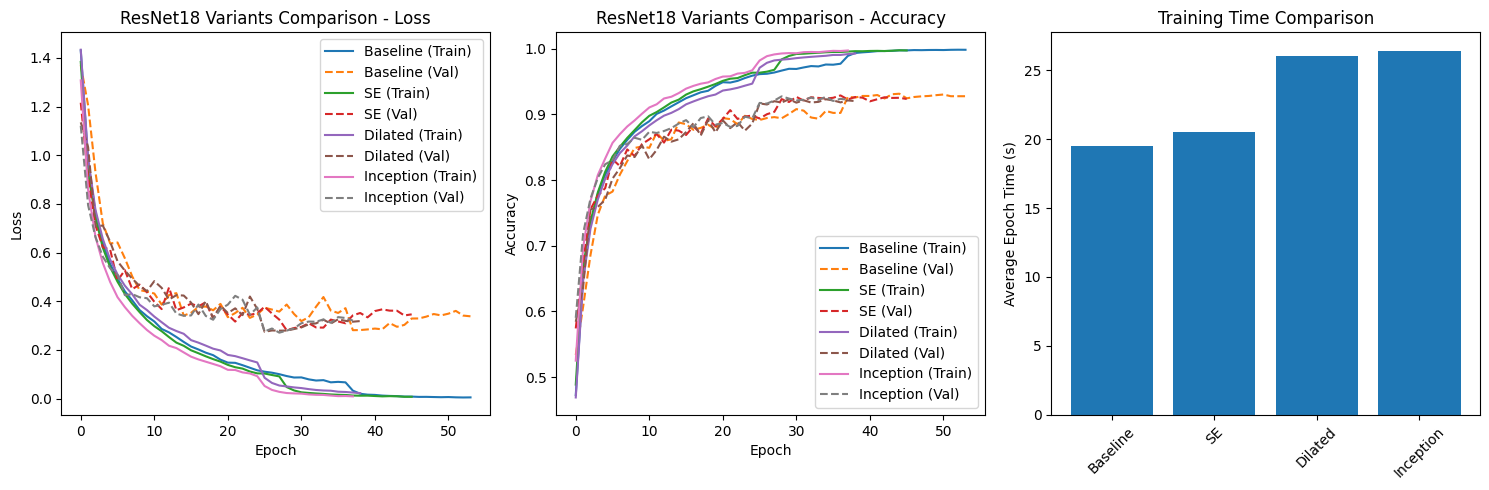

In [24]:
# %% [Cell 12]: Create Comparative Visualizations

def plot_training_curves(histories: Dict[str, Dict], title: str):
    """Plot training curves for multiple models."""
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    for name, history in histories.items():
        plt.plot(history['train_loss'], label=f'{name} (Train)')
        plt.plot(history['val_loss'], label=f'{name} (Val)', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 3, 2)
    for name, history in histories.items():
        plt.plot(history['train_acc'], label=f'{name} (Train)')
        plt.plot(history['val_acc'], label=f'{name} (Val)', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    
    # Training time plot
    plt.subplot(1, 3, 3)
    avg_times = {name: np.mean(history['epoch_times']) 
                for name, history in histories.items()}
    plt.bar(avg_times.keys(), avg_times.values())
    plt.xticks(rotation=45)
    plt.ylabel('Average Epoch Time (s)')
    plt.title('Training Time Comparison')
    
    plt.tight_layout()
    plt.show()

# Combine all training histories
all_histories = {
    'Baseline': history,
    'SE': history_se,
    'Dilated': history_dc,
    'Inception': history_inception
}

# Plot training curves
plot_training_curves(all_histories, "ResNet18 Variants Comparison")

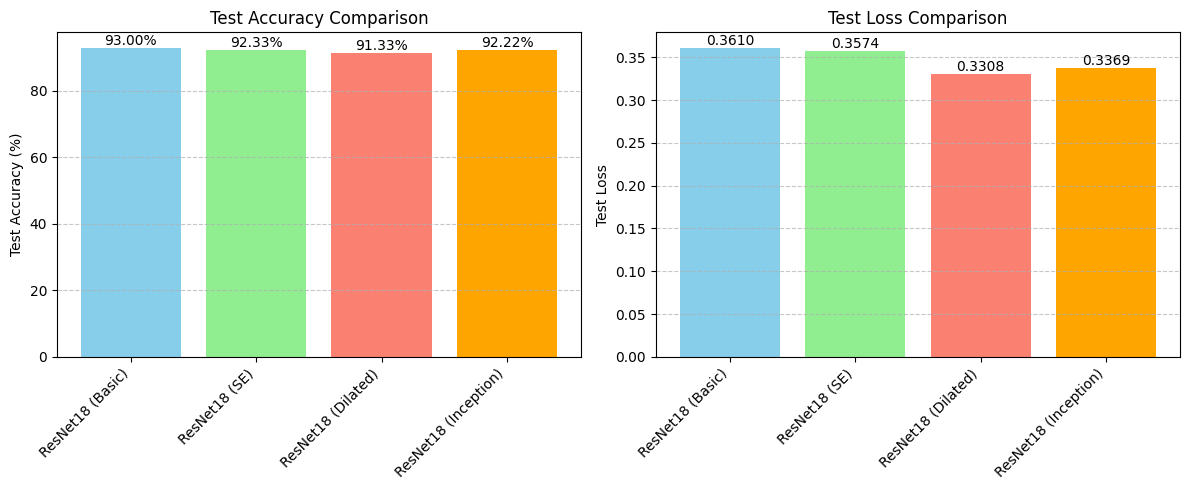

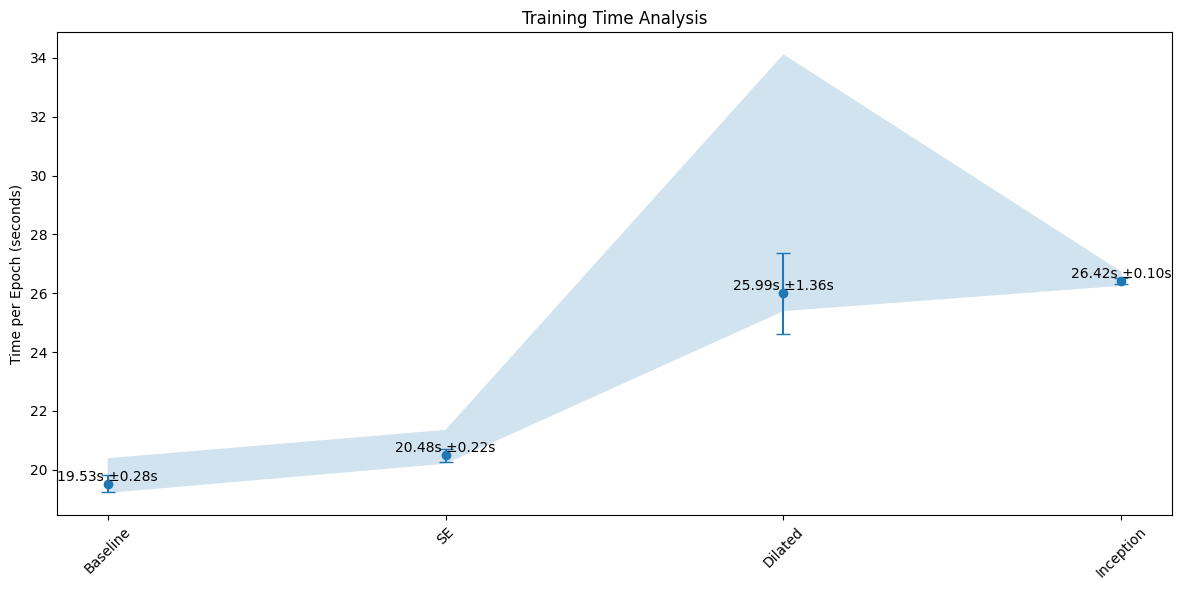


=== Training Time Statistics ===

Baseline:
  Total training time: 1054.44s
  Average epoch time: 19.53s ±0.28s
  Min epoch time: 19.21s
  Max epoch time: 20.39s

SE:
  Total training time: 942.20s
  Average epoch time: 20.48s ±0.22s
  Min epoch time: 20.20s
  Max epoch time: 21.35s

Dilated:
  Total training time: 1013.60s
  Average epoch time: 25.99s ±1.36s
  Min epoch time: 25.39s
  Max epoch time: 34.12s

Inception:
  Total training time: 1003.91s
  Average epoch time: 26.42s ±0.10s
  Min epoch time: 26.25s
  Max epoch time: 26.73s


In [25]:
# %% [Cell 13]: Test Performance Visualization

def plot_test_performance(test_results: Dict[str, Dict]):
    """Create bar plots for test performance metrics."""
    if not test_results:
        print("No test results available to plot.")
        return
        
    plt.figure(figsize=(12, 5))
    
    # Accuracy comparison
    plt.subplot(1, 2, 1)
    names = list(test_results.keys())
    accuracies = [metrics['accuracy'] * 100 for metrics in test_results.values()]
    
    bars = plt.bar(names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'orange'][:len(names)])
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom')
    
    # Loss comparison
    plt.subplot(1, 2, 2)
    losses = [metrics['loss'] for metrics in test_results.values()]
    
    bars = plt.bar(names, losses, color=['skyblue', 'lightgreen', 'salmon', 'orange'][:len(names)])
    plt.ylabel('Test Loss')
    plt.title('Test Loss Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Plot test performance comparison
plot_test_performance(test_results)

# %% [Cell 14]: Training Time Analysis

def analyze_training_times(histories: Dict[str, Dict]):
    """Analyze and visualize training time statistics."""
    time_stats = {}
    
    for name, history in histories.items():
        times = history['epoch_times']
        time_stats[name] = {
            'total': sum(times),
            'average': np.mean(times),
            'std': np.std(times),
            'min': min(times),
            'max': max(times)
        }
    
    # Create a detailed timing comparison plot
    plt.figure(figsize=(12, 6))
    
    models = list(time_stats.keys())
    avg_times = [stats['average'] for stats in time_stats.values()]
    std_times = [stats['std'] for stats in time_stats.values()]
    
    plt.errorbar(models, avg_times, yerr=std_times, fmt='o', capsize=5)
    plt.fill_between(range(len(models)), 
                    [stats['min'] for stats in time_stats.values()],
                    [stats['max'] for stats in time_stats.values()],
                    alpha=0.2)
    
    plt.ylabel('Time per Epoch (seconds)')
    plt.title('Training Time Analysis')
    plt.xticks(rotation=45)
    
    # Add value annotations
    for i, (avg, std) in enumerate(zip(avg_times, std_times)):
        plt.text(i, avg, f'{avg:.2f}s ±{std:.2f}s',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n=== Training Time Statistics ===")
    for name, stats in time_stats.items():
        print(f"\n{name}:")
        print(f"  Total training time: {stats['total']:.2f}s")
        print(f"  Average epoch time: {stats['average']:.2f}s ±{stats['std']:.2f}s")
        print(f"  Min epoch time: {stats['min']:.2f}s")
        print(f"  Max epoch time: {stats['max']:.2f}s")

# Analyze training times
analyze_training_times(all_histories)

### Висновки
Проведені експерименти з різними архітектурними модифікаціями ResNet18 показали цікаві результати:

1. Базова точність: Базова модель ResNet18 показала найкращу точність на тестовому наборі (93.00%), що свідчить про її ефективність для задачі класифікації CIFAR-10. При цьому час навчання базової моделі був найменшим (19.53 ± 0.28 секунд на епоху).
2. SE блоки: Модифікація з SE блоками досягла точності 92.33%, що дещо нижче базової моделі, але з відносно невеликим збільшенням часу навчання (20.48 ± 0.22 секунд на епоху). Графіки навчання показують, що SE модель швидше сходиться на тренувальному наборі, але має дещо гірше узагальнення.
3. Розширені згортки: Версія з розширеними згортками показала найнижчу точність (91.33%), але при цьому досягла найкращого значення функції втрат на тесті (0.3308). Час навчання суттєво збільшився до 25.99 ± 1.36 секунд на епоху, що може бути критичним для великих датасетів.
4. Inception блоки: Модель з Inception блоками досягла точності 92.22%, що близько до результату SE блоків, але з найбільшим часом навчання (26.42 ± 0.10 секунд на епоху). Графіки показують хорошу збіжність на тренувальному наборі.

Загалом, результати демонструють, що для даного датасету та задачі додаткова складність архітектурних модифікацій не призвела до покращення точності порівняно з базовою моделлю. Це може бути пов'язано з відносною простотою датасету CIFAR-10 та достатньою ємністю базової архітектури ResNet18. Проте варто зазначити, що всі модифіковані архітектури показали добру здатність до навчання та прийнятні результати, що робить їх потенційно корисними для інших, складніших задач комп'ютерного зору.